# **EDA e Pré-processamento**

## **Recomendação**

O dataset do desafio ocupa muito armazenamento, para facilitar o desenvolvomento utilizei-o por meio do drive, o [dataset](https://drive.google.com/drive/folders/1xH3UCNXJn3OeAwchLdFP4PfDr6FLKTq5?usp=sharing), caso queira executar esse Colab baixe o dataset e coloque na raiz do seu Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importando lib**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2
import tensorflow as tf

## **EDA**

### **Inicializando o dataset de treino**

In [ ]:
path = "/content/drive/MyDrive/ligia-compviz"
df_train = pd.read_csv(f'{path}/train.csv')

In [ ]:
display(df_train.head())

,id,label
0,NORMAL-8648239-0004.jpeg,0
1,NORMAL-388586-0003.jpeg,0
2,NORMAL-7824011-0001.jpeg,0
3,NORMAL-8234246-0001.jpeg,0
4,NORMAL-5505017-0001.jpeg,0


### 📖 Dicionário de Variáveis

| Variável | Descrição |
|----------|----------|
| ID | ID único da imagem, remete ao nome do arquivo |
| Label | Diágnostico (0 = Normal, 1 = Pneumonia) |


O dataset foi carregado no ambiente e uma visualização inicial das primeiras linhas foi feita para verificação da estrutura dos dados.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5232 non-null   object
 1   label   5232 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.9+ KB


In [ ]:
display(df_train['label'].value_counts())

counts = df_train['label'].value_counts()
percent = counts / counts.sum() * 100
print("Proporção entre os diagnósticos!")
print(f"{round(percent, 2)}")


,count
label,
1,3883
0,1349


Proporção entre os diagnósticos!
label
1    74.22
0    25.78
Name: count, dtype: float64


### **ANÁLISE DE DADOS FALTANTES, DUPLICATAS OU INCONSISTENTE**

In [ ]:
print(df_train.isna().sum())
print(f"Dados duplicados: {df_train.duplicated().sum()}")

id       0
label    0
dtype: int64
Dados duplicados: 0


Nenhum valor nulo ou instância duplicada foi encontrado.

### **Analisando imagem**

In [ ]:
plt.style.use('ggplot')

In [ ]:
imagens_normal = glob(f"{path}/train/train/NORMAL/*.jpeg")
imagens_pneumonia = glob(f"{path}/train/train/PNEUMONIA/*.jpeg")

print(f"Imagens normais: {len(imagens_normal)}")
print(f"Imagens pneumonia: {len(imagens_pneumonia)}")
print(f"Total: {len(imagens_normal) + len(imagens_pneumonia)}")


Imagens normais: 1349
Imagens pneumonia: 3883
Total: 5232


O tamanho das variaveis imagens condizem com os valores observados do dataset!

#### **Observação visual dos raios-x**

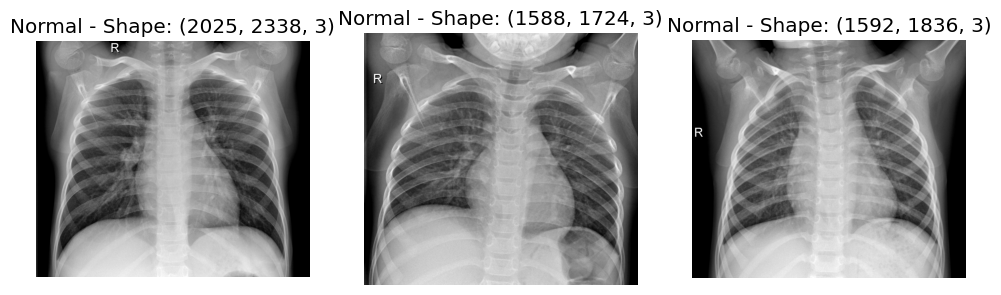

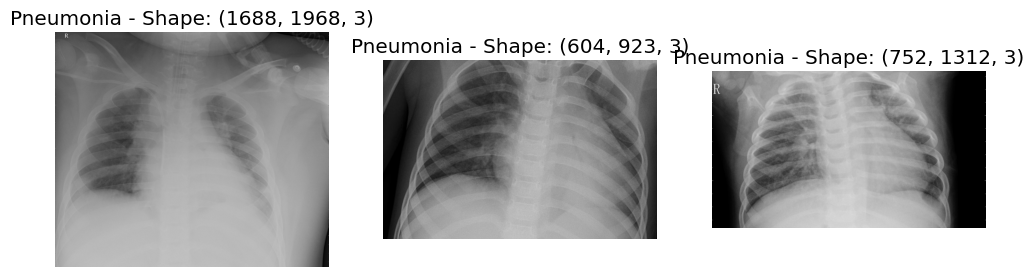

In [ ]:
def plot_samples(paths, title, qColuns):
    plt.figure(figsize=(12, 4))
    for i in range(qColuns):
        img = cv2.imread(paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, qColuns, i+1)
        plt.imshow(img)
        plt.title(f"{title} - Shape: {img.shape}")
        plt.axis('off')
    plt.show()

plot_samples(imagens_normal, "Normal", 3)
plot_samples(imagens_pneumonia, "Pneumonia", 3)

**Análise Visual e Fundamentação Clínica**

Através da análise exploratória visual, é perceptível que os raios-x de pulmões diagnosticados com pneumonia apresentam áreas de opacidade conhecidas como **infiltrados pulmonares.** Visualmente, essas áreas assemelham-se a uma **"nuvem branca"** ou névoa que diminui a nitidez dos campos pulmonares e apaga os contornos vasculares nítidos vistos nos pulmões normais.

**Esta observação está em estrita conformidade com a bibliografia médica radiológica,** que define a pneumonia como um preenchimento alveolar por exsudato, resultando em consolidações que aumentam a densidade local (radiopacidade). Esse fenômeno físico é o que gera o contraste visual identificado. Portanto, essa característica será o principal padrão de textura extraído pelas camadas convolucionais do modelo para a diferenciação das classes, garantindo que o aprendizado da máquina esteja fundamentado em critérios diagnósticos reais.

## **Pré-processamento**

### **Criando Feature**

O dataset só possui duas colunas, o id e o label, para facilitar o desenvolvimento é necessário criar mais uma feature que remeta ao caminho para a imagem.

In [ ]:
# Existe uma padrão nos nomes das imagens/id,
# os ids dos raios x normais são do tipo NORMAL-xxxxx.jpeg
# Vou explorar esse padrão

def gerar_path_imagem(id_imagem):
    if(id_imagem.startswith("NORMAL")):
      return f"{path}/train/train/NORMAL/{id_imagem}"
    else:
      return f"{path}/train/train/PNEUMONIA/{id_imagem}"

In [ ]:
df_train['path'] = df_train['id'].apply(gerar_path_imagem)
# Embaralhando os dados (importante para o treino não viciar)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_train.head()


,id,label,path
0,NORMAL-9543520-0001.jpeg,0,/content/drive/MyDrive/ligia-compviz/train/tra...
1,NORMAL-8714707-0001.jpeg,0,/content/drive/MyDrive/ligia-compviz/train/tra...
2,VIRUS-2750119-0003.jpeg,1,/content/drive/MyDrive/ligia-compviz/train/tra...
3,BACTERIA-1157929-0001.jpeg,1,/content/drive/MyDrive/ligia-compviz/train/tra...
4,BACTERIA-6171093-0001.jpeg,1,/content/drive/MyDrive/ligia-compviz/train/tra...


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5232 non-null   object
 1   label   5232 non-null   int64 
 2   path    5232 non-null   object
dtypes: int64(1), object(2)
memory usage: 122.8+ KB


### **Preparação dos Datasets e Divisão de Dados**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Garantir que os labels sejam lidos como strings para o flow_from_dataframe
df_train['label'] = df_train['label'].astype(str)

# Divisão em Treino (80%) e Validação (20%) com estratificação
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    random_state=42,
    stratify=df_train['label']
)

print(f"Total de amostras para treino: {len(train_df)}")
print(f"Total de amostras para validação: {len(val_df)}")

Total de amostras para treino: 4185
Total de amostras para validação: 1047


Nesta etapa, garantir que os rótulos estejam no formato correto (string) para o processamento do Keras. Utilizei a técnica de **Holdout** com estratificação para separar 20% dos dados para validação. A estratificação é crucial em dados médicos para garantir que a proporção de casos positivos (Pneumonia) seja idêntica tanto no treino quanto na validação, evitando viés na avaliação.

### **Configuração do Data Augmentation e Normalização**

In [ ]:
# Configuração para o conjunto de treino (com aumento de dados)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=7,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

# Configuração para validação (apenas normalização)
val_datagen = ImageDataGenerator(rescale=1./255)

Defini as transformações que serão aplicadas às imagens em tempo real. Para o conjunto de treino, aplicei Data Augmentation (rotação e zoom leves), o que aumenta a robustez experimental e ajuda a prevenir o overfitting. Para ambos os conjuntos, realizei o Rescale (divisão por 255), normalizando os pixels para o intervalo $[0, 1]$, facilitando a convergência do algoritmo de otimização.

### **Instanciação dos Geradores de Imagem (Data Pipelines)**

In [ ]:
# Gerador de Treino
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Gerador de Validação
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.


Criei os geradores que alimentarão o modelo em lotes (batches). As imagens são redimensionadas para $224 \times 224$ pixels para manter a compatibilidade com arquiteturas de Transfer Learning (DenseNet/ResNet). Mantei 3 canais de cor (RGB) para aproveitar os pesos pré-treinados no ImageNet, mesmo tratando-se de exames originalmente em escala de cinza.

## **Conclusão**

Neste notebook foi realizada a Análise Exploratória de Dados (EDA) e o pré-processamento do dataset de pneumonia — explorando a distribuição das classes, padrões visuais das imagens, criação de novas features e criação de geradores de imagem.

Com os dados analisados e preparados, o próximo passo é o desenvolvimento e treinamento do modelo. Acesse o notebook de desenvolvimento:

👉 [Abrir Notebook de Desenvolvimento](https://colab.research.google.com/drive/1Sxt6mv19PnW5Rmwn70IUZejKAxRK7P-L)

Lá todo o pipeline de treinamento é construído com base nas observações e transformações levantadas nesta análise.